# M2S13.01: Exploring alternative clustering methods

## 01.1. Library and files loading

In [33]:
library(Seurat)
library(clustree)
library(cluster)
library(ggplot2)
library(dplyr)

# BiocManager::install('glmGamPoi')
# devtools::install_github("immunogenomics/presto")

In [34]:
count_matrix <- read.csv("count_matrix.csv", row.names = 1, check.names = FALSE)
metadata <- read.csv("metadata.csv", row.names = 1)

In [47]:
unique(metadata$Selection)

[1] "Unpanned"             "Microglia(CD45)"      "Astrocytes(HEPACAM)" 
[4] "Neurons(Thy1)"        "Endothelial(BSC)"     "Oligodendrocytes(GC)"

## 01.2. Quick Seurat workflow (see previous classes)

In [38]:
# Create a Seurat object
seurat_object <- CreateSeuratObject(counts = count_matrix, meta.data = metadata, min.cells = 3, min.features = 200)

# Standard workflow
seurat_object <- SCTransform(seurat_object, verbose = FALSE)
seurat_object <- RunPCA(seurat_object, features = VariableFeatures(object = seurat_object))
seurat_object <- FindNeighbors(seurat_object, dims = 1:30)
seurat_object <- FindClusters(seurat_object, resolution = 0.5)
seurat_object <- RunUMAP(seurat_object, dims = 1:30)

Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”
PC_ 1 
Positive:  CD74, SPP1, CCL3, HLA-DRA, CCL4, C3, SAT1, RGS1, APOE, A2M 
	   CD83, C1QB, HLA-DRB1, LAPTM5, CTSB, SGK1, IL1B, FCGBP, SRGN, OLR1 
	   SLC11A1, HLA-DPA1, GPR183, C1QA, DUSP1, ACSL1, VSIG4, RNASET2, EGR2, PLEK 
Negative:  CLU, TUBA1A, BCAN, APOD, PTPRZ1, GFAP, ALDOC, GPM6B, MEG3, SPARCL1 
	   CPE, VCAN, TSPAN7, GPM6A, C1orf61, CNN3, SCD5, AQP4, PLLP, SLC1A2 
	   GPRC5B, DNER, AGT, S100B, SPOCK1, EGFR, ATP1A2, SERPINE2, FXYD6, CDR1 
PC_ 2 
Positive:  APOD, PLLP, MEG3, BCAN, SPOCK1, CDR1, DNER, VCAN, GPR17, TNR 
	   SCD5, HTRA1, CCL3, MEGF11, CCL4, PDGFRA, OLIG1, PDZD2, NLGN3, EHD3 
	   CNP, ATCAY, OMG, ALDOC, TUBB4A, CA10, TSPAN7, SMOC1, EDIL3, CSPG4 
Negative:  CLU, VIM, CHI3L1, GFAP, SERPINA3, MT2A, CYR61, IGFBP7, TNC, LDHA 
	   FN1, CD44, ANXA2, GAPDH, ANXA1, IGFBP2, C8orf4, SOD2, AQP4, SPARC 
	   ALDOA, CNN3, COL1A2, S100A10, C1R, TGFBI, TPI1, CXCL14, TIMP1, ENO2 
PC_ 3 
Positive:  RNASE1, TGFBI,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3567
Number of edges: 115898

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9170
Number of communities: 15
Elapsed time: 0 seconds


18:31:46 UMAP embedding parameters a = 0.9922 b = 1.112

18:31:46 Read 3567 rows and found 30 numeric columns

18:31:46 Using Annoy for neighbor search, n_neighbors = 30

18:31:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:31:47 Writing NN index file to temp file /tmp/RtmpnR2WhH/file2a98d2cd85bde

18:31:47 Searching Annoy index using 1 thread, search_k = 3000

18:31:47 Annoy recall = 100%

18:31:48 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:31:49 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

18:31:49 Using 'irlba' for PCA

18:31:49 PCA: 2 components explained 40.46% variance

18:31:49 Scaling init to sdev = 1

18:31:49 Commencing optimization for 500 epochs, with 139912 

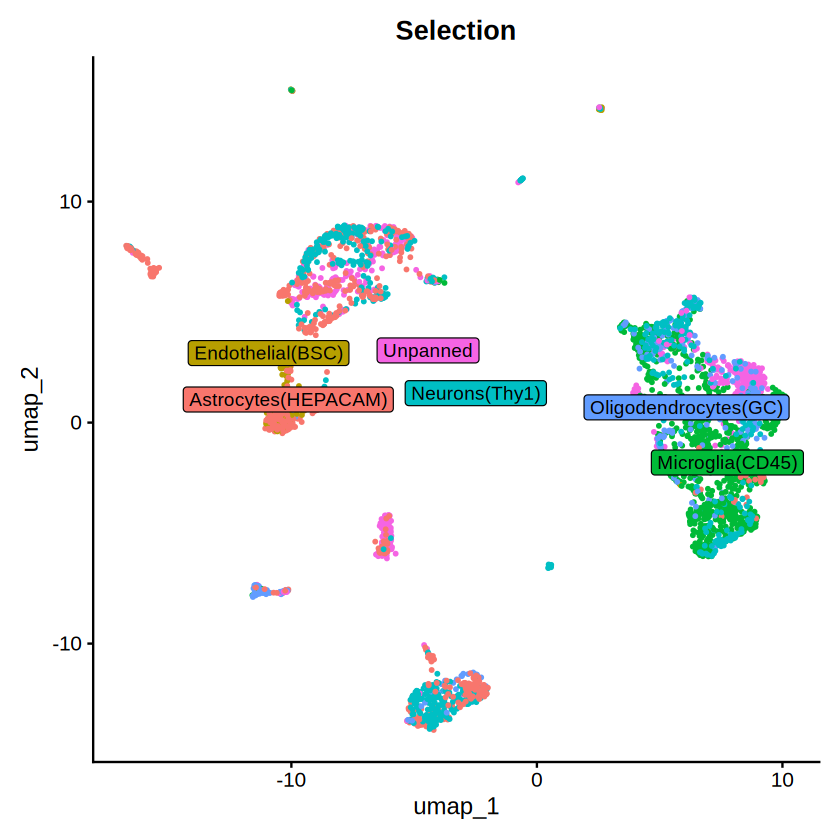

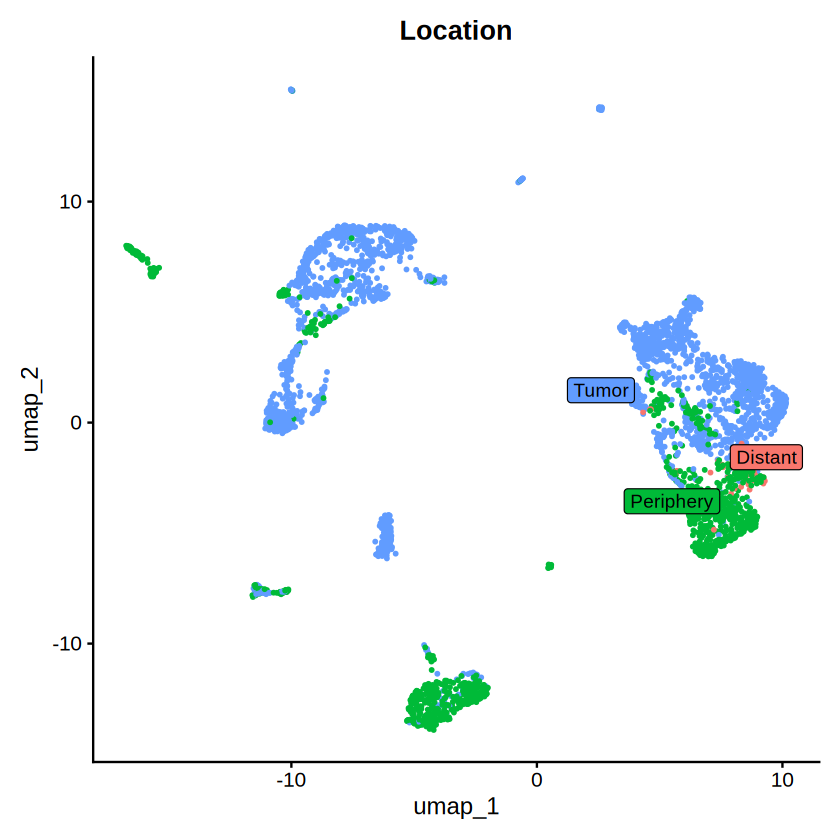

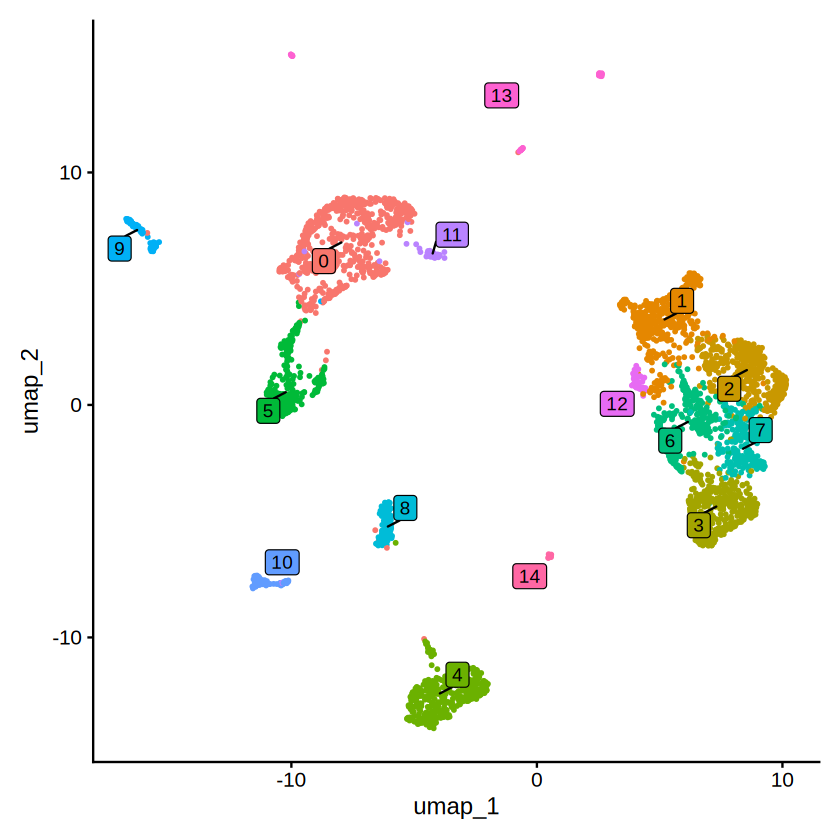

In [39]:
DimPlot(seurat_object, reduction = "umap", group.by = "Selection", label = TRUE, label.box = TRUE, repel = TRUE) + NoLegend()
DimPlot(seurat_object, reduction = "umap", group.by = "Location", label = TRUE, label.box = TRUE, repel = TRUE) + NoLegend()
DimPlot(seurat_object, reduction = "umap", label = TRUE, label.box = TRUE, repel = TRUE) + NoLegend()

## 01.3. Selecting optimal clustering resolution

In [40]:
resolutions <- seq(from = 0.2, to = 2, by = 0.2)
seurat_object <- FindClusters(seurat_object, resolution = resolutions)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3567
Number of edges: 115898

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9521
Number of communities: 12
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3567
Number of edges: 115898

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9280
Number of communities: 13
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3567
Number of edges: 115898

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9083
Number of communities: 17
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3567
Number of edges: 115898

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8918
Number of communities: 20
Elapsed time: 0 seconds
Modularity Optim

### _Ad oculus_: cluster tree

In [43]:
seurat_object@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,Selection,Location,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,SCT_snn_res.0.2,SCT_snn_res.0.4,SCT_snn_res.0.6,SCT_snn_res.0.8,SCT_snn_res.1,SCT_snn_res.1.2,SCT_snn_res.1.4,SCT_snn_res.1.6,SCT_snn_res.1.8,SCT_snn_res.2
,<fct>,<dbl>,<int>,<chr>,<chr>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1001000173.G8,SeuratProject,270429,2145,Unpanned,Tumor,376364,2143,0,11,1,0,4,5,3,8,9,8,11,11
1001000173.D4,SeuratProject,169375,1037,Unpanned,Tumor,373020,1038,10,21,8,9,12,13,14,17,20,19,19,21
1001000173.B4,SeuratProject,727429,5829,Unpanned,Tumor,377420,5818,0,10,1,0,4,5,3,10,12,12,8,10
1001000173.A2,SeuratProject,705653,4065,Unpanned,Tumor,377428,4053,0,3,1,0,5,3,4,2,6,5,9,3
1001000173.E2,SeuratProject,390799,2310,Unpanned,Tumor,376825,2309,0,23,1,0,5,3,4,2,9,8,23,23
1001000173.F6,SeuratProject,345092,2810,Unpanned,Tumor,376878,2805,0,3,1,0,5,3,4,2,6,5,9,3
1001000173.B12,SeuratProject,846179,5996,Unpanned,Tumor,377152,5771,0,11,1,0,4,5,3,8,9,8,11,11
1001000173.D6,SeuratProject,636289,4428,Unpanned,Tumor,377316,4425,0,19,1,0,5,3,15,16,17,10,20,19
1001000173.H1,SeuratProject,504293,4488,Unpanned,Tumor,377031,4483,0,3,1,0,5,3,4,2,6,5,9,3


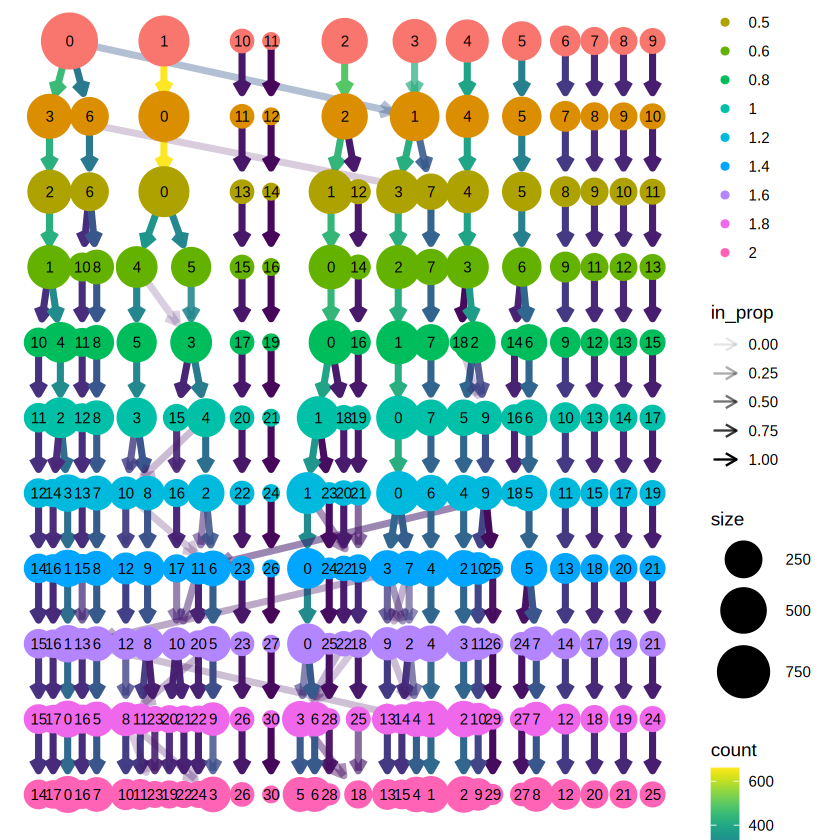

In [41]:
# Draw cluster tree with clustree to assess stability across resolutions
clustree(seurat_object, prefix = "SCT_snn_res.")

### Metrics-based: silhouette score

   Resolution Avg_Silhouette
1         0.2      0.1256472
2         0.4      0.1386639
3         0.6      0.1514233
4         0.8      0.1371455
5         1.0      0.1443205
6         1.2      0.1523909
7         1.4      0.1504298
8         1.6      0.1531681
9         1.8      0.1547207
10        2.0      0.1561062


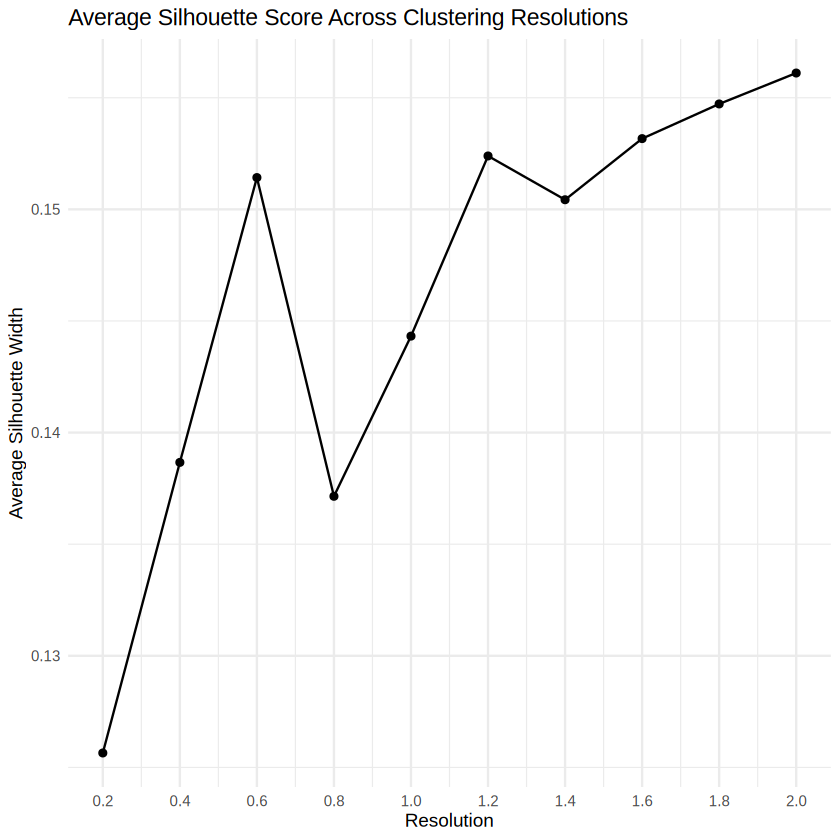

In [44]:
pca_embeddings <- Embeddings(seurat_object, reduction = "pca")
dist_matrix <- dist(pca_embeddings)

# Compute silhouette scores for each clustering resolution
sil_scores <- sapply(resolutions, function(res) {
  col_name <- paste0("SCT_snn_res.", res)
  cluster_ids <- as.numeric(as.factor(seurat_object@meta.data[[col_name]]))
  if (length(unique(cluster_ids)) < 2) {
    return(NA) 
  }
  sil <- silhouette(cluster_ids, dist_matrix)
  if (is.null(dim(sil))) {
    return(NA)
  }
  mean(sil[, "sil_width"])
})

sil_df <- data.frame(Resolution = resolutions, Avg_Silhouette = sil_scores)
print(sil_df)

ggplot(sil_df, aes(x = Resolution, y = Avg_Silhouette)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(title = "Average Silhouette Score Across Clustering Resolutions",
       y = "Average Silhouette Width") +
  scale_x_continuous(breaks = sil_df$Resolution)

In [45]:
seurat_object <- FindClusters(seurat_object, resolution = 0.6)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3567
Number of edges: 115898

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9083
Number of communities: 17
Elapsed time: 0 seconds


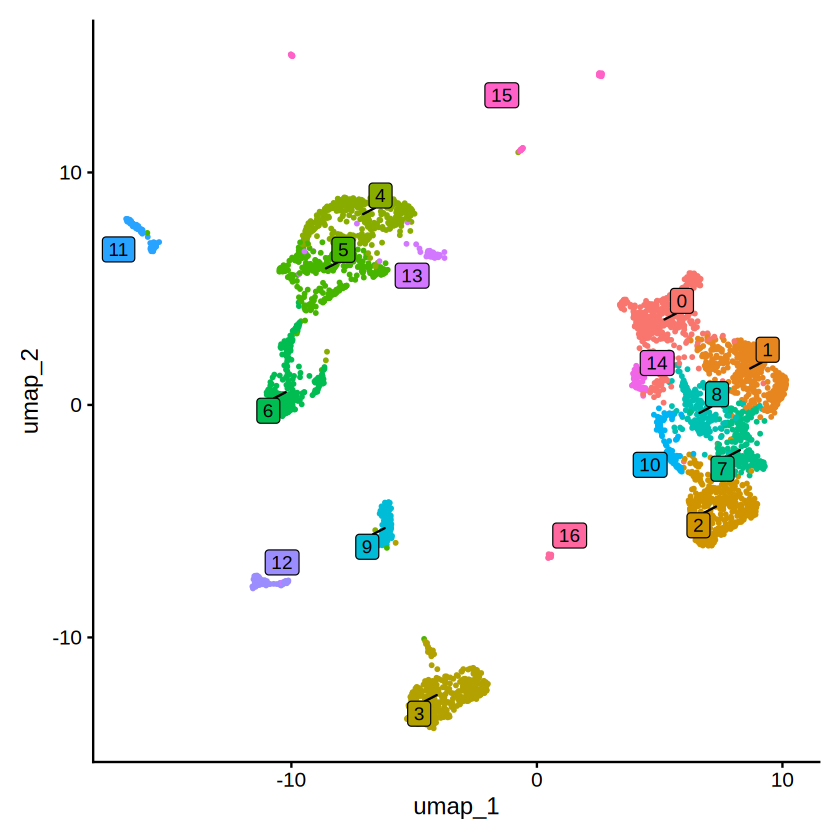

In [46]:
DimPlot(seurat_object, reduction = "umap", label = TRUE, label.box = TRUE, repel = TRUE) + NoLegend()

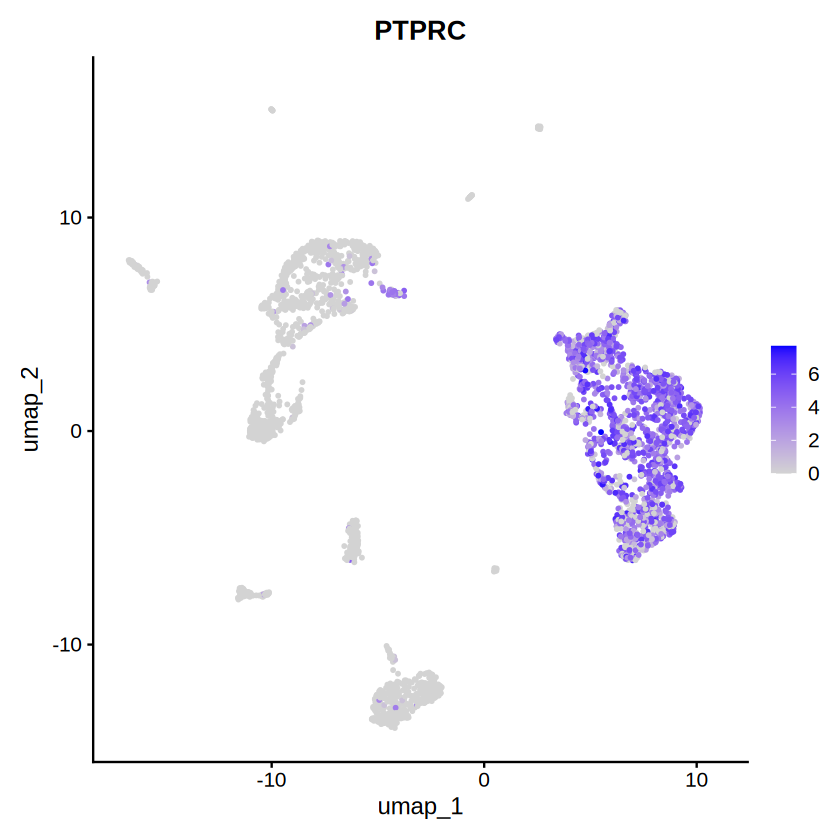

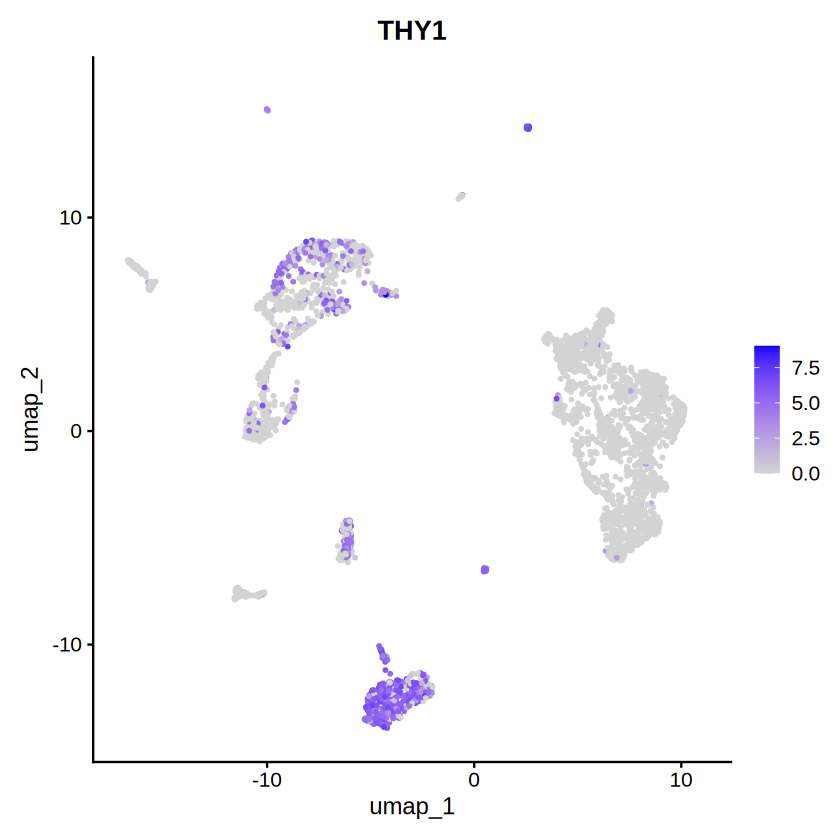

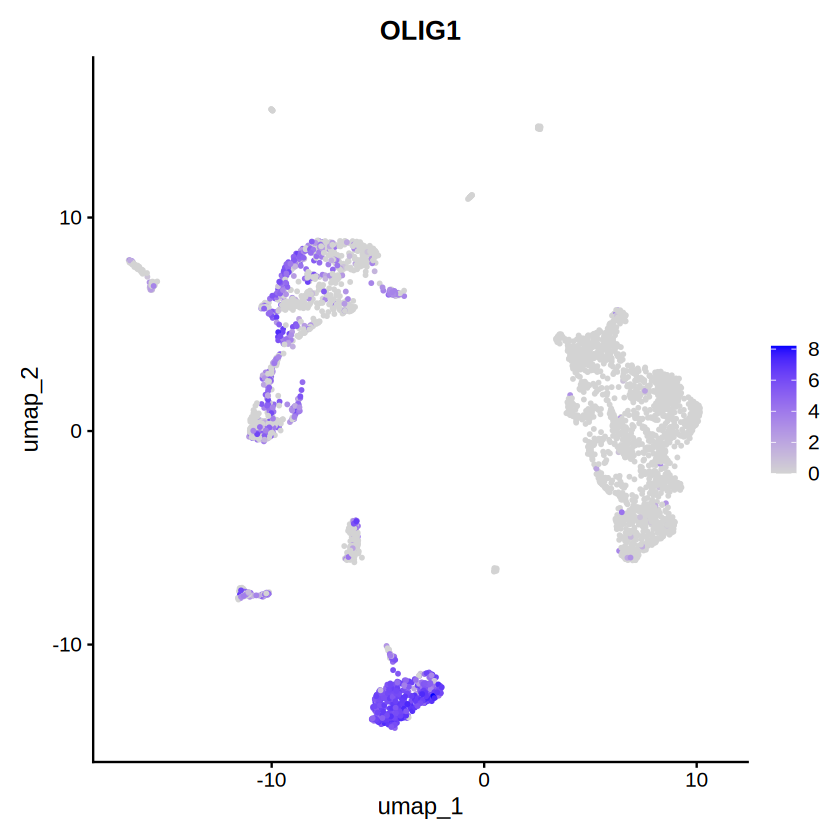

In [48]:
FeaturePlot(seurat_object, features = "PTPRC")
FeaturePlot(seurat_object, features = "THY1")
FeaturePlot(seurat_object, features = "OLIG1")

In [ ]:
markers <- FindMarkers(seurat_object, ident.1 = "0", ident.2 = "2", min.diff.pct = 0.25,test.use = "Wilcoxon")

In [50]:
markers %>% filter(abs(avg_log2FC) > 0.5, p_val_adj < 0.05) %>% arrange(desc(avg_log2FC))

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
THBS1,2.259145e-59,13.332976,0.499,0.010,4.477399e-55
VCAN,2.412889e-109,12.768276,0.798,0.038,4.782104e-105
MARCO,2.113963e-60,12.581167,0.506,0.010,4.189664e-56
SLC16A10,5.948291e-85,11.651765,0.649,0.005,1.178892e-80
ANPEP,5.990632e-87,10.934951,0.662,0.007,1.187283e-82
TGM2,3.828052e-43,10.552730,0.392,0.012,7.586816e-39
SLCO4A1,1.864023e-26,9.686675,0.268,0.014,3.694308e-22
CLMN,7.533524e-28,9.392624,0.274,0.012,1.493069e-23
CD48,1.959154e-32,9.379488,0.336,0.026,3.882848e-28


## 01.4. Exporting as AnnotData object for future analysis

In [52]:
library(SeuratDisk)

In [53]:
SaveH5Seurat(seurat_object, filename = "01_object.h5Seurat")

Creating h5Seurat file for version 3.1.5.9900

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

Adding variable features for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



In [54]:
Convert("01_object.h5Seurat", dest = "h5ad", overwrite = TRUE)

Validating h5Seurat file

Adding scale.data from SCT as X

Adding data from SCT as raw

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding SCT_snn as neighbors



In [55]:
saveRDS(seurat_object, "01_seurat_obj.Rds")